# CNN for Fashion-MNIST dataset

### Problem Description

We're provided with a dataset of small grayscale images depicting various clothing objects. They are subdivided into ten classes, and our goal is to build a CNN that predicts those classes as precisely as possible. We will build several (simple) CNNs and then compare their performace and efficiency.  

### Loading and preparing the dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

from random import randrange
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#loading the train and the test set
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape, X_test.shape)

Using TensorFlow backend.


(60000, 28, 28) (10000, 28, 28)


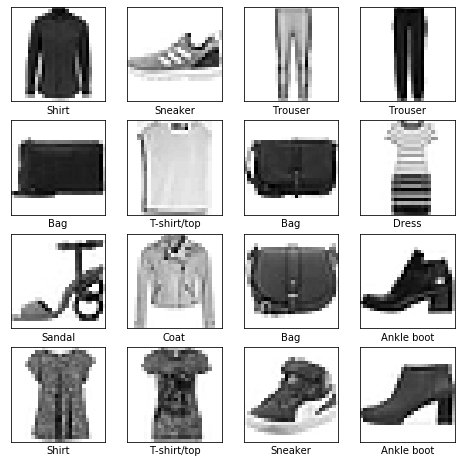

In [3]:
#labeling the classes and displaying some images from the dataset
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    k = randrange(6000)
    plt.imshow(X_train[k], cmap=plt.cm.binary)
    plt.xlabel(class_labels[y_train[k]])
plt.show()


The train and the test sets are given as a three-dimensional vectors. However, in order to feed our CNN with the images, we need them to be 4D vectors. That's why wee need to add an additional dimension. This additional dimension tells the number of channels. Since our images are in grayscale, we have only one channel.

Also, we scale the values of every entry, and one-hot encode the classes.

In [4]:
#Adding the fourth axis
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)

In [5]:
#Scaling the values to [0,1] range
X_train = X_train.astype('float')
X_test = X_test.astype('float')

X_train = X_train/255
X_test = X_test/255

In [6]:
#Encoding the classes
from keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Building the CNN

Here we build a pretty simple CNN, consisting of two convolutional layers equipped with max-pool layer each, and two fully-connected layers. We use 3x3 kernels, add padding, use small regularization and the dropout. ReLu and softmax (in the last layer) are used as activation functions. We use the categorical crossentropy for the loss function, and nadam optimizer. 

We perform the training in 45 epochs, which takes approximately 40 minutes, since 1 epoch takes less than a minute to finish. 

(Since I have an integrated Intel graphic card, I had to the train the network using CPU; running it on GPU would allow me to train it significantly faster, for more epochs, which could lead to better accuracy)

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from keras.optimizers import nadam
from keras.regularizers import l2

In [8]:
cnn = Sequential()

cnn.add(Conv2D(input_shape = (28, 28, 1), filters = 32, 
              kernel_size = (3,3), activation = 'relu', 
              padding='same', kernel_regularizer=l2(1e-4)))
cnn.add(MaxPool2D((2,2)))

cnn.add(Conv2D(filters = 32, 
              kernel_size = (3,3), activation = 'relu', 
              padding='same', kernel_regularizer=l2(1e-4)))
cnn.add(MaxPool2D((2,2)))


cnn.add(Flatten())

cnn.add(Dense(units = 256, activation='relu', 
              kernel_regularizer=l2(1e-4)))
cnn.add(Dropout(0.35))
cnn.add(Dense(units = 10, activation = 'softmax'))

In [9]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               401664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [10]:
cnn.compile(loss = 'categorical_crossentropy', 
           optimizer = nadam(lr = 0.001),
           metrics = ['accuracy'])

In [11]:
history = cnn.fit(X_train, y_train, batch_size = 256, epochs = 45, 
        shuffle = True, validation_data= (X_test, y_test), 
        verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/45
60000/60000 [==============================] - 43s 725us/step - loss: 0.6408 - accuracy: 0.7860 - val_loss: 0.4612 - val_accuracy: 0.8429
Epoch 2/45
60000/60000 [==============================] - 39s 648us/step - loss: 0.4128 - accuracy: 0.8673 - val_loss: 0.4161 - val_accuracy: 0.8661
Epoch 3/45
60000/60000 [==============================] - 39s 642us/step - loss: 0.3670 - accuracy: 0.8822 - val_loss: 0.4165 - val_accuracy: 0.8591
Epoch 4/45
60000/60000 [==============================] - 39s 648us/step - loss: 0.3386 - accuracy: 0.8929 - val_loss: 0.3427 - val_accuracy: 0.8910
Epoch 5/45
60000/60000 [==============================] - 38s 639us/step - loss: 0.3163 - accuracy: 0.9014 - val_loss: 0.3322 - val_accuracy: 0.8957
Epoch 6/45
60000/60000 [==============================] - 39s 647us/step - loss: 0.2998 - accuracy: 0.9074 - val_loss: 0.3251 - val_accuracy: 0.8938
Epoch 7/45
60000/60000 [==============================] 

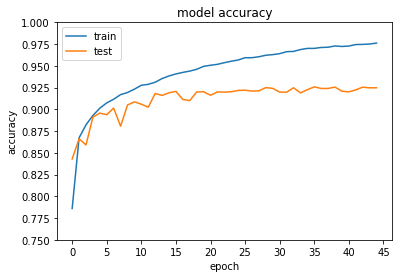

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(np.arange(0,46,5))
plt.ylim(0.75,1), plt.yticks(np.arange(0.75,1.025,0.025))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Accuracy Analysis

At the end of the training, our model classified the images with the 97.6% accuracy on the training set, and 92.5% on the test set. We can argue an overfit, but still, the performance on the test set is okay. Moreover, if we focus on the test set performance, we can gain the similar accuracy even after ~15 minutes of training (on CPU), since the model achieves it after 15 epochs. 

Let's now draw the confusion matrix for our model, and see how it performs on several randomly chosen images.

In [36]:
from sklearn.metrics import confusion_matrix

y_pred = cnn.predict_classes(X_test)
y_test_class = y_test.argmax(1)

cm = confusion_matrix(y_test_class, y_pred)

In [47]:
import itertools

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    # Plot the confusion matrix as an image
    plt.figure(figsize = (14, 14))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    
    # Tick marks show the labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add the numbers to the plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")

    # Formatting
    plt.tight_layout()
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.ylabel('True label', size = 18)
    plt.xlabel('\n Predicted label', size = 18)

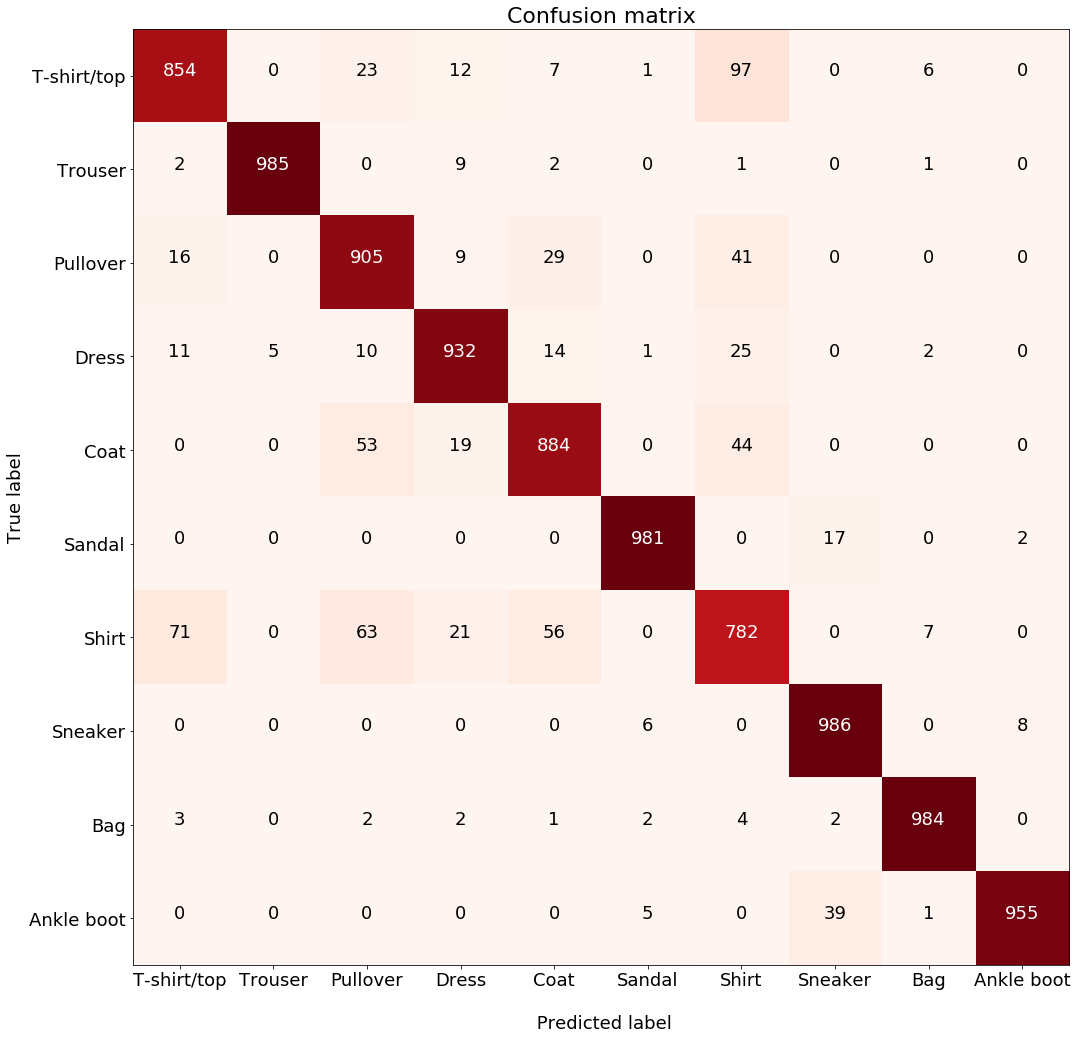

In [48]:
plot_confusion_matrix(cm, class_labels)

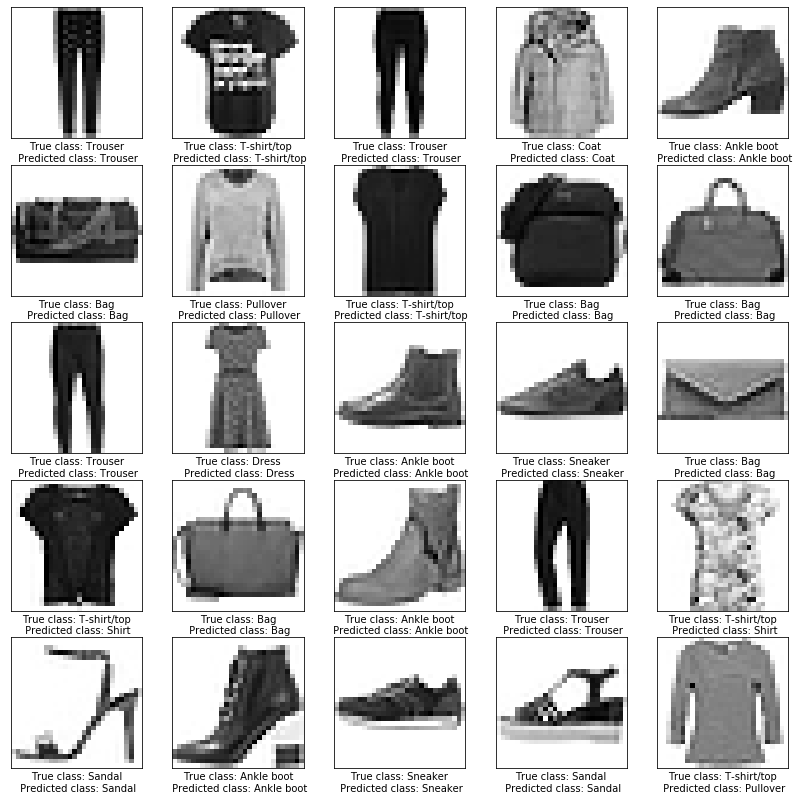

In [46]:
X_test_sq = np.squeeze(X_test, axis = 3)
plt.figure(figsize=(14,14))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    k = randrange(6000)
    plt.imshow(X_test_sq[k], cmap=plt.cm.binary)
    plt.xlabel('True class: ' + class_labels[y_test_class[k]] +
        '\n Predicted class: ' + class_labels[y_pred[k]])
plt.show()

### Conclusions

We see that our model has a bit of a trouble distinguishing among T-shirt/shirts/coat classes and sneaker/boot classes. It shows some overfit, but it still performs fine on a test set, its architecture is quite simple and can be trained relatively fast. 